<a href="https://colab.research.google.com/github/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN/blob/main/Rice_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRCP-1001: Rice Leaf Disease Detection**

## **Problem Statement**
Build a deep learning model to detect and classify three major rice leaf diseases:
1. **Leaf Smut**
2. **Brown Spot**
3. **Bacterial Leaf Blight**

---

### **Objective:**
- Prepare a complete data analysis report (EDA).
- Train CNN models to classify the three diseases.
- Analyze techniques like **Data Augmentation** for model improvement.
- Compare model performances and recommend the best model for production.

**Dataset:** 120 images (40 per class)


In [1]:
!git clone https://github.com/nandhakumar-v-19/Rice-Leaf-Disease-using-CNN.git

Cloning into 'Rice-Leaf-Disease-using-CNN'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 182 (delta 35), reused 139 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (182/182), 39.03 MiB | 20.80 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
# !pip install -r /content/Rice-Leaf-Disease-using-CNN/requirements.txt

#!pip install tensorflow

# **Import Libraries**

In [3]:
# Basic data and numerical libraries
import os                      # To handle file and folder paths
import numpy as np             # For numerical operations and array handling
import pandas as pd            # For tabular data manipulation

# Visualization libraries
import matplotlib.pyplot as plt # To plot charts and images
import seaborn as sns           # To make beautiful visual plots

# Image processing library
import cv2                      # OpenCV for reading and resizing images

# TensorFlow & Keras libraries for deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.models import Sequential                       # To build sequential CNN models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN layers
from tensorflow.keras.optimizers import Adam                          # Optimizer
from tensorflow.keras.callbacks import EarlyStopping                  # To stop training early if no improvement

# Scikit-learn utilities for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# **Dataset Loading & Exploration (EDA)**

In [4]:
# Upload your dataset
data_dir = '/content/Rice-Leaf-Disease-using-CNN/RiceLeaf Dataset'

In [5]:
# List all the class folders inside the dataset
classes = os.listdir(data_dir)
print("Classes found:", classes)

# Count the number of images in each class
count_dict = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

print("Count of datas present inside each class:")
print(count_dict)

Classes found: ['Bacterial leaf blight', 'Brown spot', 'Leaf Smut']
Count of datas present inside each class:
{'Bacterial leaf blight': 40, 'Brown spot': 40, 'Leaf Smut': 39}


In [6]:
#Convert it into dataframe
df_counts = pd.DataFrame(list(count_dict.items()), columns=["Class Name", "Image Count"])
df_counts

,Class Name,Image Count
0,Bacterial leaf blight,40
1,Brown spot,40
2,Leaf Smut,39


# **Visualize the class distribution**

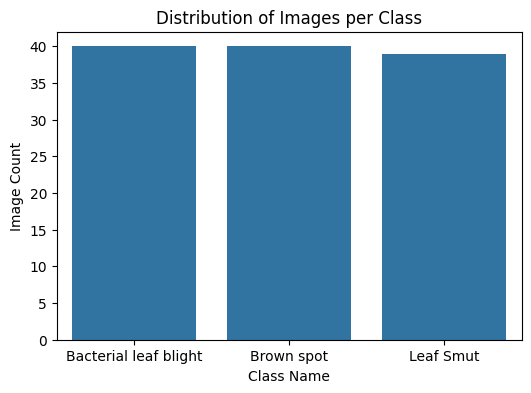

In [7]:
# Bar chart for class distribution
plt.figure(figsize=(6,4))
sns.barplot(x="Class Name", y="Image Count", data=df_counts)
plt.title("Distribution of Images per Class")
plt.show()

# **Display sample images**

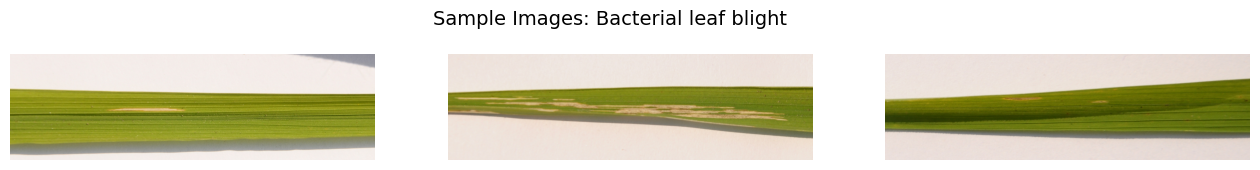

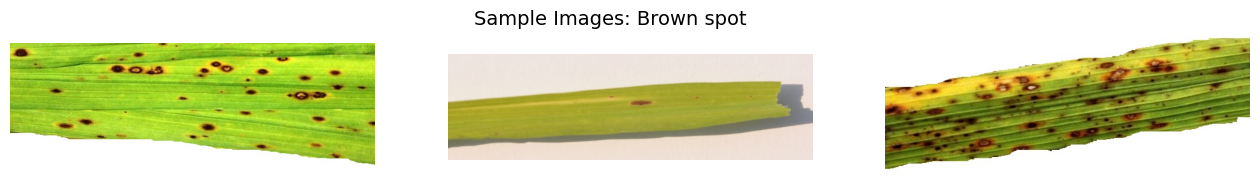

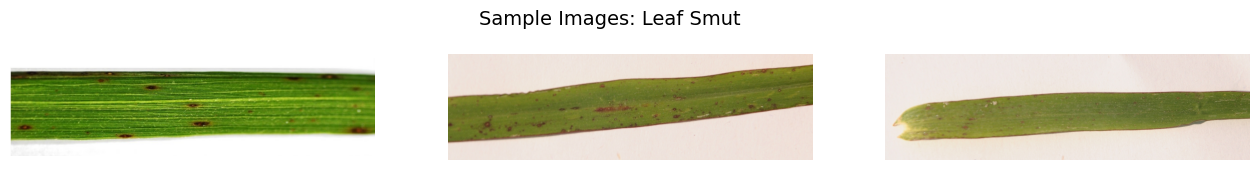

In [8]:
import random

# Display 3 random images from each class for visual inspection
for cls in classes:
    plt.figure(figsize=(16, 2))
    plt.suptitle(f"Sample Images: {cls}", fontsize=14)

    # Randomly select 3 images from the current class
    sample_imgs = random.sample(os.listdir(os.path.join(data_dir, cls)), 3)

    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(data_dir, cls, img_name)
        img = plt.imread(img_path)    # Read image
        plt.subplot(1, 3, i+1)        # Create subplot
        plt.imshow(img)
        plt.axis("off")               # Hide axes
    plt.show()

# **Image Preprocessing**

In [9]:
# Define image size (we resize all images to the same dimension)
IMG_SIZE = (128, 128)

# Initialize lists to store images and labels
data = []
labels = []

# Loop through each class and read all images
for cls in classes:
    folder_path = os.path.join(data_dir, cls)  # Path to the class folder
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)  # Full image path
        img = cv2.imread(img_path)                      # Read image using OpenCV
        img = cv2.resize(img, IMG_SIZE)                 # Resize image to (128x128)
        data.append(img)                                # Add image to data list
        labels.append(cls)                              # Add corresponding label

# Convert lists to NumPy arrays
data = np.array(data) / 255.0   # Normalize pixel values (0–1)
labels = np.array(labels)

print("✅ Data shape:", data.shape)
print("✅ Labels count:", len(labels))

✅ Data shape: (119, 128, 128, 3)
✅ Labels count: 119


# **Split Dataset for Training and Testing**

In [10]:
# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 95
Testing samples: 24


# **Label Encoding**

In [11]:
# Convert text labels (like "Leaf smut") into numeric labels (0, 1, 2)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Convert numeric labels to one-hot encoded format (required for classification)
from tensorflow.keras.utils import to_categorical
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print("✅ Encoded labels shape:", y_train_enc.shape)

✅ Encoded labels shape: (95, 3)


# **Data Augmentation**

In [12]:
# Create an ImageDataGenerator for training data to generate more diverse images
train_datagen = ImageDataGenerator(
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Randomly flip images horizontally
)

# For test data, we only normalize (no augmentation)
test_datagen = ImageDataGenerator()

# Apply generators
train_gen = train_datagen.flow(X_train, y_train_enc, batch_size=16)
test_gen = test_datagen.flow(X_test, y_test_enc, batch_size=16)

# **Model Building and Training (Multiple CNN Architectures)**

In [13]:
#Model 1 — Simple CNN

# Build a simple CNN model
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),  # First convolution layer

    MaxPooling2D(2,2),                                             # Downsample

    Flatten(),                                                     # Flatten 2D image to 1D vector

    Dense(64, activation='relu'),                                  # Hidden dense layer

    Dense(3, activation='softmax')                                 # Output layer with 3 classes
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the model with optimizer and loss function
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model-1 and compare performance
history1 = model1.fit(train_gen, validation_data=test_gen, epochs=15)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.2876 - loss: 12.9254 - val_accuracy: 0.3333 - val_loss: 1.9836
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.3028 - loss: 1.4421 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.3410 - loss: 1.1033 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.3665 - loss: 1.1069 - val_accuracy: 0.4167 - val_loss: 1.1921
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.3483 - loss: 1.1396 - val_accuracy: 0.5000 - val_loss: 1.0466
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.5088 - loss: 1.0174 - val_accuracy: 0.4167 - val_loss: 1.0223
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.4723 - loss: 0.9792 - val_accuracy: 0.4583 - val_loss: 0.9955
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.5080 - loss: 0.9079 - val_accuracy: 0.4583 - val_loss

In [15]:
# Build a deeper CNN for better learning
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),  # Conv layer 1

    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),                           # Conv layer 2

    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation='relu'),                                  # More neurons for deeper learning

    Dropout(0.3),                                                   # Dropout to prevent overfitting

    Dense(3, activation='softmax')                                  # Output layer
])


In [16]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model-2 and compare performance
history2 = model2.fit(train_gen, validation_data=test_gen, epochs=15)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step - accuracy: 0.4460 - loss: 2.0239 - val_accuracy: 0.4167 - val_loss: 1.0541
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.3696 - loss: 1.1058 - val_accuracy: 0.6667 - val_loss: 1.0132
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.5778 - loss: 1.0110 - val_accuracy: 0.2917 - val_loss: 1.0355
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.3734 - loss: 1.0213 - val_accuracy: 0.6250 - val_loss: 0.9431
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.5630 - loss: 0.9740 - val_accuracy: 0.5417 - val_loss: 0.9224
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.4529 - loss: 0.9483 - val_accuracy: 0.4167 - val_loss: 0.9960
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.5348 - loss: 0.9395 - val_accuracy: 0.4583 - val_loss: 0.8947
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.5849 - loss: 1.0003 - val_accuracy: 0.4167 - val_loss:

# **Model Performance Visualization**

In [17]:
# Evaluate both models on test data
acc1 = model1.evaluate(test_gen)[1]
print(f"Model 1 Accuracy: {acc1:.2f}")


acc2 = model2.evaluate(test_gen)[1]
print(f"Model 2 Accuracy: {acc2:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4931 - loss: 1.0087
Model 1 Accuracy: 0.46
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7014 - loss: 0.7809
Model 2 Accuracy: 0.71


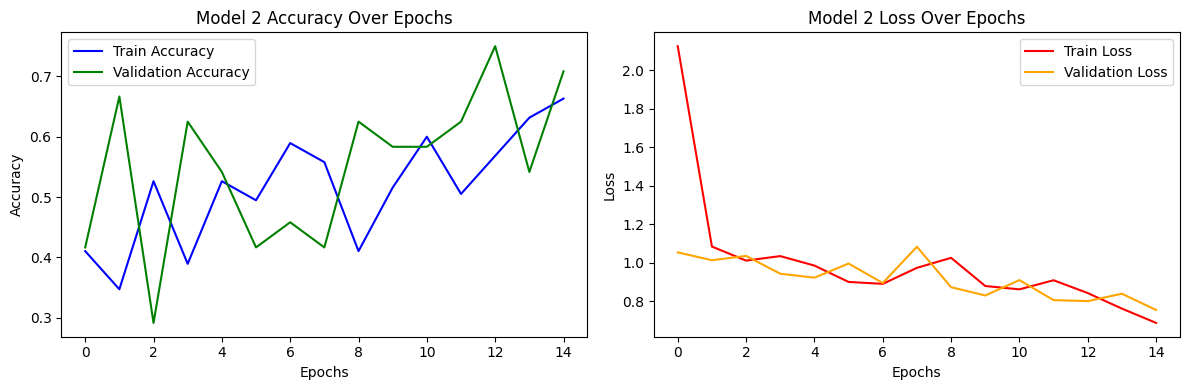

In [18]:
# 📈 Plot accuracy and loss curves for the best model (Model 2)

plt.figure(figsize=(12, 4))


# 🔹 Plot 1: Training vs Validation Accuracy
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st position)
plt.plot(history2.history['accuracy'], label='Train Accuracy', color='blue')  # Plot training accuracy
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='green')  # Plot validation accuracy
plt.title('Model 2 Accuracy Over Epochs')  # Set plot title
plt.xlabel('Epochs')                       # Label x-axis (epochs = training cycles)
plt.ylabel('Accuracy')                     # Label y-axis (accuracy value)
plt.legend()                               # Add legend to differentiate lines

# 🔹 Plot 2: Training vs Validation Loss
plt.subplot(1, 2, 2)  # Create second subplot (1 row, 2 columns, 2nd position)
plt.plot(history2.history['loss'], label='Train Loss', color='red')  # Plot training loss
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange')  # Plot validation loss
plt.title('Model 2 Loss Over Epochs')      # Set plot title
plt.xlabel('Epochs')                       # Label x-axis
plt.ylabel('Loss')                         # Label y-axis
plt.legend()                               # Add legend

plt.tight_layout()  # Adjust spacing to prevent overlap between subplots
plt.show()          # Display both accuracy and loss plots

# **Model Evaluation & Metrics**

# **Classification Report**

In [20]:
# Predict labels for test set
y_pred = np.argmax(model2.predict(test_gen), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Classification Report:
                        precision    recall  f1-score   support

Bacterial leaf blight       0.42      0.62      0.50         8
           Brown spot       0.33      0.12      0.18         8
            Leaf Smut       0.44      0.50      0.47         8

             accuracy                           0.42        24
            macro avg       0.40      0.42      0.38        24
         weighted avg       0.40      0.42      0.38        24



# **Confusion Matrix**

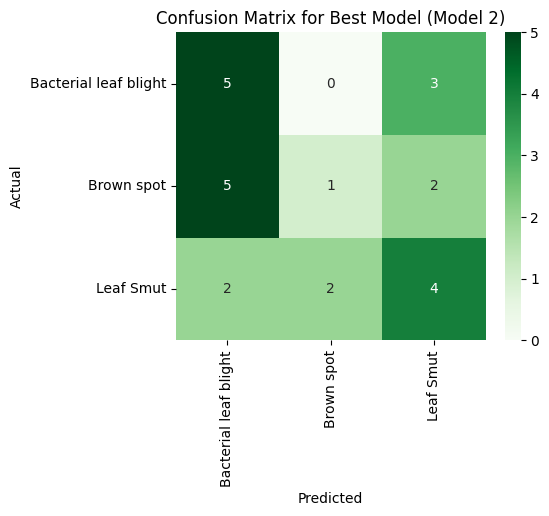

In [21]:
# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix for Best Model (Model 2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Final validation accuracy**

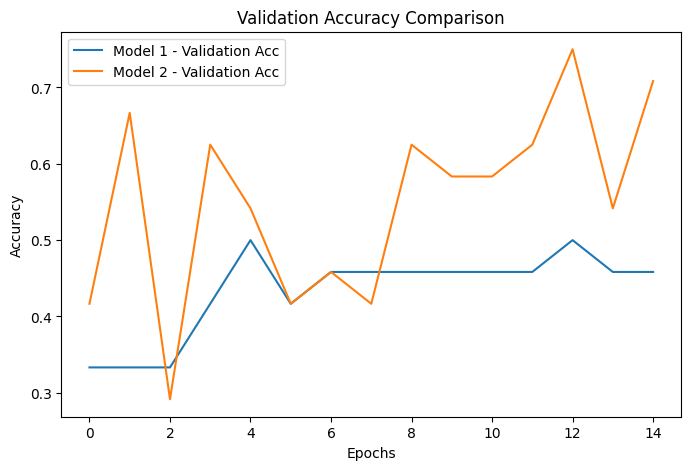

In [22]:
# Plot training accuracy for both models

plt.figure(figsize=(8,5))
plt.plot(history1.history['val_accuracy'], label='Model 1 - Validation Acc')
plt.plot(history2.history['val_accuracy'], label='Model 2 - Validation Acc')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
